# Import Libraries

In [13]:
import sys
sys.path.append("/home/felix/PycharmProjects/Quantum-Challenge/")
import pandas as pd
import xarray as xr
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import traceback

# Keywords

Classical approach: selection of the trajectory with the shortest Euclidean distance to the target in order to minimize the distance traveled, i.e. save fuel and time

try to find argument on how many planes can fit into single voxel with

# TODO

- formulate constraints
- come upm with quanutm model
- formulate test traj more realistic, i.e. jumping from middle of voxel to .. 

# Define Boundaries

x: Longitude in deg

y: Latitude in deg

z: Flight Level

t: Timestampe in DateTime format

In [5]:
max_x = 30 
min_x = -30 

max_y = 60  
min_y = 34  

spacing_xy = 2

max_z = 400
min_z = 100
spacing_z = 20

In [9]:
x_arr = np.arange(min_x, max_x + spacing_xy, spacing_xy)
y_arr  = np.arange(min_y, max_y + spacing_xy, spacing_xy)
z_arr   = np.arange(min_z, max_z + spacing_z, spacing_z)

box_3d = np.zeros((x_arr.shape[0], y_arr.shape[0], z_arr.shape[0]))

# Load flight Data 

In [4]:
flight_df = pd.read_csv("../data/flights.csv", sep=";")

<IPython.core.display.Javascript object>


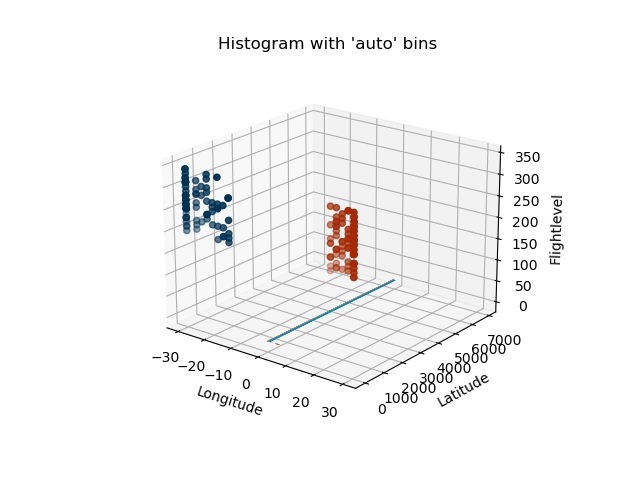

In [120]:
%matplotlib notebook
flight_dict = flight_df.to_dict()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x_s = np.fromiter(flight_dict["start_longitudinal"].values(), dtype=float)
y_s = np.fromiter(flight_dict["start_latitudinal"].values(), dtype=float)
z_s = np.fromiter(flight_dict["start_flightlevel"].values(), dtype=float)

x_e = np.fromiter(flight_dict["end_longitudinal"].values(), dtype=float)
y_e = np.fromiter(flight_dict["end_latitudinal"].values(), dtype=float)
z_e = np.fromiter(flight_dict["start_flightlevel"].values(), dtype=float)


ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Flightlevel")

ax.scatter(x_s, y_s, z_s,c="#003153")
ax.scatter(x_e, y_e, z_e, c="#A42A04")

#ax.invert_zaxis()

plt.show()

# Load velocity and fuel consumption data

In [18]:
fuel_df = pd.read_csv("../data/bada_data.csv", sep=";")
cruise_df_temp = pd.read_csv("../data/bada_data.csv", sep=";").iloc[:,[0,1,2]]
climb_df = pd.read_csv("../data/bada_data.csv", sep=";").iloc[:,[0,3,4,5]]
descent_df = pd.read_csv("../data/bada_data.csv", sep=";").iloc[:,[0,6,7,8]]

In [226]:
cruise_df = cruise_df_temp.drop(index=[0,1,2,3,4,5,6,7,8]).reset_index() # remove FL below 100
cruise_df.drop(cruise_df[cruise_df.FL<200].index, inplace=True)
cruise_df = cruise_df.reset_index()
cruise_df.drop(columns=["level_0","index"],inplace=True)

# Load climate data

In [159]:
convert_dict = {
    600: [100,120,140], 
    550: [160], 
    500: [180], 
    450: [200,220], 
    400: [240], 
    350: [260,280], 
    300: [300,320],
    250: [340], 
    225: [360], 
    200: [380,400]} 

In [162]:
ds = xr.open_dataset("../data/aCCF_0623_p_spec.nc")
climate_df_temp = ds.to_dataframe()
climate_df = climate_df_temp.reset_index()
climate_df.drop(columns=["LEVEL11_24_bnds","bnds","SG_NOX","SG_DCONT","SG_H2O","E022"], inplace=True)
climate_df.drop(climate_df[climate_df.LONGITUDE<-30].index, inplace=True)
climate_df = climate_df.reset_index()

hpa_old = climate_df["LEVEL11_24"].to_numpy()
fl_mapped = []#np.zeros(len(hpa_old))
rem_index = []

for i in range(len(hpa_old)):
    if hpa_old[i] in convert_dict:
        fl_mapped.append( convert_dict[hpa_old[i]])
    else:
        fl_mapped.append(float("nan")  )
        rem_index.append(i)

climate_df["FL"] = fl_mapped
climate_df.drop(rem_index, inplace=True)
climate_df = climate_df.reset_index()
climate_df.drop(columns=["level_0","index"],inplace=True)

# Define functions to relate measured data to parametrized voxels

In [54]:
def x_to_km(deg):
    "return km"
    return deg*85

def y_to_km(deg):
    "return km"
    return deg*111

In [126]:
def find_x(x_hat):
    inx = (np.abs(x_arr - x_hat)).argmin()
    return x_arr[inx]

def find_y(y_hat):
    inx = (np.abs(y_arr - y_hat)).argmin()
    return y_arr[inx]

def find_z(z_hat):
    inx = (np.abs(z_arr - z_hat)).argmin()
    return z_arr[inx]

In [176]:
def find_z_arr(z_hat):
    
    nearest_val = z_hat
    difference = z_hat
    
    for cnt, arr in enumerate(convert_dict.values()):
        for test_fl in arr:
            if np.abs(test_fl - z_hat) < difference:
                nearest_val = arr
                difference = np.abs(test_fl - z_hat)
    
    return nearest_val

In [228]:
def find_fuel(df, FL_val):
    """"returns TAS and fuel consumption in kg/min """
    inx = (np.abs(df["FL"].to_numpy() - FL_val )).argmin()
    cl_inx = df.index[inx]
    return df.iloc[cl_inx].values[2],float(df.iloc[cl_inx].values[3].replace(",","."))

# find_fuel(cruise_df,22.2)

In [230]:
#The trajectory for each airplane is defined as a list of points, altitudes, and time stamps
def consumed_fuel(trajectory):
    c_fuel = 0 
    for cnt in range(len(trajectory)-1):
        #delta_x = np.abs(trajectory[cnt+1]["x"] - trajectory[cnt]["x"] )
        #delta_y = np.abs(trajectory[cnt+1]["y"] - trajectory[cnt]["y"] )
        z = trajectory[cnt+1]["z"] 
        delta_t = np.abs(trajectory[cnt+1]["t"] - trajectory[cnt]["t"] ).astype(float)
        
        consumption_rate = find_fuel(cruise_df,z)[-1] # in kg/min
        
        c_fuel += consumption_rate * delta_t/60 
                
    return c_fuel
# test_traj = [{"x": 25, "y":50, "z":400 , "t":np.datetime64("2018-06-23 06:00:00")  }, {"x": 27, "y":50, "z":400 , "t": np.datetime64("2018-06-23 12:00:00") }]

In [210]:
def find_climate(df, x, y, z, t):
    
    scaled_x = find_x(x)
    scaled_y = find_y(y)
    scaled_z = find_z_arr(z)
    
    index_arr = []
    for cnt, fl in enumerate(df["FL"].to_numpy()):
        if fl == scaled_z:
            index_arr.append(True)
        else:
            index_arr.append(False)
    
    temp_series = df.loc[(df["LONGITUDE"] == scaled_x) & (df["LATITUDE"] == scaled_y) & (index_arr), "TIME"].dt.hour
    try:    
        inx = (np.abs(temp_series.to_numpy() - ( (t-t.astype('datetime64[D]'))/3600).astype(int)   )).argmin()
    except:
        print(scaled_x,scaled_y,scaled_z,temp_series)
        print(traceback.format_exc()) 
        inx = 0 
    cl_inx = temp_series.index[inx]
    ret = df.iloc[cl_inx].values[-2]
    
    return ret 

# find_climate(climate_df, x=30, y=56, z=400, t=np.datetime64("2018-06-23 06:00:00"))

# Define navigation functions

In [53]:
def rad_change_direction(v,angle):
    rad = angle*np.pi/180
    return v**2/(np.tan(rad))*0.0000269
rad_change_direction(400,25)
# normalized to km

9.229957785873141

longest way through voxel is diagonal, therefore use that as upper bound 

In [238]:
x_to_km(2), y_to_km(2), np.sqrt(170**2 + 222**2)

(170, 222, 279.6140196771256)

In [243]:
170*222*0.06096/(0.3048*9.26*279)

2.9215727257948396

I.e. max 3 planes in a voxel at a given time 

# Define Cost function and constraints

In [270]:
# sum over traj and see if more then 3 airplanes are in voxel at given time 
tr_1 = trajec_arr[0]
box_3d = np.zeros((x_arr.shape[0], y_arr.shape[0], z_arr.shape[0]))
timestamp_dict = {}
for c_1, x in enumerate(x_arr):
    for c_2, y in enumerate(y_arr):
        for c_3, z in enumerate(z_arr):
            for c_4, tr  in enumerate(tr_1):
        
                if x == x_arr[(np.abs(x_arr - tr["x"]  )).argmin()] and y == y_arr[(np.abs(y_arr - tr["y"]  )).argmin()] and z == z_arr[(np.abs(z_arr - tr["y"]  )).argmin()]:
                    box_3d[c_1][c_2][c_3] += 1
                    timestamp_dict[str(c_1)+"_"+str(c_2)+"_"+str(c_3)] = tr["t"]
                    print(str(c_1)+"_"+str(c_2)+"_"+str(c_3),tr["t"])

0_11_0 2018-06-23T07:18:33
1_11_0 2018-06-23T07:22:06
1_11_0 2018-06-23T07:25:39
1_11_0 2018-06-23T07:29:12
1_11_0 2018-06-23T07:32:45
2_11_0 2018-06-23T07:36:18
2_11_0 2018-06-23T07:39:51
2_11_0 2018-06-23T07:43:24
2_11_0 2018-06-23T07:46:57
3_11_0 2018-06-23T07:50:30
3_11_0 2018-06-23T07:54:03
3_11_0 2018-06-23T07:57:36
4_11_0 2018-06-23T08:01:09
4_11_0 2018-06-23T08:04:42
4_11_0 2018-06-23T08:08:15
4_11_0 2018-06-23T08:11:48
5_11_0 2018-06-23T08:15:21
5_11_0 2018-06-23T08:18:54
5_11_0 2018-06-23T08:22:27
5_11_0 2018-06-23T08:26:00
6_11_0 2018-06-23T08:29:33
6_11_0 2018-06-23T08:33:06
6_11_0 2018-06-23T08:36:39
7_11_0 2018-06-23T08:40:12
7_12_0 2018-06-23T08:43:45
7_12_0 2018-06-23T08:47:18
7_12_0 2018-06-23T08:50:51
8_12_0 2018-06-23T08:54:24
8_12_0 2018-06-23T08:57:57
8_12_0 2018-06-23T09:01:30
8_12_0 2018-06-23T09:05:03
9_12_0 2018-06-23T09:08:36
9_12_0 2018-06-23T09:12:09
9_12_0 2018-06-23T09:15:42
10_12_0 2018-06-23T09:19:15
10_12_0 2018-06-23T09:22:48
10_12_0 2018-06-23T09:26:2

In [265]:
np.histogram(box_3d.flatten(), bins=[0,1,2,3,4])

(array([6914,    3,    1,   26]), array([0, 1, 2, 3, 4]))

In [269]:
timestamp_dict

{'0_11_0': numpy.datetime64('2018-06-23T07:18:33'),
 '1_11_0': numpy.datetime64('2018-06-23T07:32:45'),
 '2_11_0': numpy.datetime64('2018-06-23T07:46:57'),
 '3_11_0': numpy.datetime64('2018-06-23T07:57:36'),
 '4_11_0': numpy.datetime64('2018-06-23T08:11:48'),
 '5_11_0': numpy.datetime64('2018-06-23T08:26:00'),
 '6_11_0': numpy.datetime64('2018-06-23T08:36:39'),
 '7_11_0': numpy.datetime64('2018-06-23T08:40:12'),
 '7_12_0': numpy.datetime64('2018-06-23T08:50:51'),
 '8_12_0': numpy.datetime64('2018-06-23T09:05:03'),
 '9_12_0': numpy.datetime64('2018-06-23T09:15:42'),
 '10_12_0': numpy.datetime64('2018-06-23T09:29:54'),
 '11_12_0': numpy.datetime64('2018-06-23T09:44:06'),
 '12_12_0': numpy.datetime64('2018-06-23T09:54:45'),
 '13_12_0': numpy.datetime64('2018-06-23T10:08:57'),
 '14_12_0': numpy.datetime64('2018-06-23T10:23:09'),
 '15_12_0': numpy.datetime64('2018-06-23T10:33:48'),
 '16_12_0': numpy.datetime64('2018-06-23T10:48:00'),
 '17_12_0': numpy.datetime64('2018-06-23T11:02:12'),
 '18

In [ ]:
Voxel x,y,z at what times are planes in

In [234]:
# constraining parameters
con_vertical = 0.3048 # km
con_horizont = 9.26 # km
con_inclination = 25 # deg only above this
p = 100 

In [74]:
def C(trajectory):
    
    c_fuel = consumed_fuel(trajectory) # kg 
    
    #delta_CO2 = 6.94 * 10**(-12) # K/kg fuel
    
    effect_sum = np.sum([find_climate(climate_df, x=point["x"], y=point["y"], z=point["z"], t=point["t"]) for point in trajectory])
    
    delta_c = effect_sum*10**(-12) # K/kg fuel
    
    return (delta_c)*c_fuel

2.571302233640753e-07

# Optimize flights classicaly

In [ ]:
traj should jump from vox to vox

In [98]:
trajec_arr = []
for index, t, z, x_s, y_s, x_e, y_e in flight_df.to_numpy():
    
    delta_x = x_to_km(np.abs(x_e-x_s))
    delta_y = y_to_km(np.abs(y_e-y_s))
    total_dist = np.sqrt(delta_x**2 + delta_y**2)

    x_tr = np.linspace(x_s,x_e,100)
    y_tr = np.linspace(y_s,y_e,100)
    fl_tr = np.ones(100)*z
    t_tr = [np.datetime64('2018-06-23 '+t)]
    
    temp_trajec = []
    for i in range(99):
        point_x = x_to_km(x_tr[i+1] - x_tr[i])
        point_y = y_to_km(y_tr[i+1] - y_tr[i])
        point_dist = np.sqrt(point_x**2 + point_y**2)
        # point fl soon

        point_t = int(3600 * point_dist/ (find_fuel(cruise_df,z)[0] * 1.852))

        t_tr.append(t_tr[i] + np.timedelta64(point_t,'s'))
        temp_trajec.append({"x": x_tr[i+1], "y":y_tr[i+1], "z":z , "t":t_tr[i] + np.timedelta64(point_t,'s')  })
    trajec_arr.append(temp_trajec)

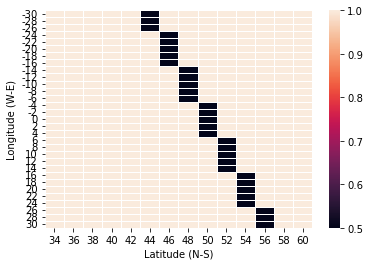

In [113]:
tr_1 = trajec_arr[44]
box_2d = np.zeros((x_arr.shape[0], y_arr.shape[0]))
for c_1, i in enumerate(x_arr):
    for c_2, j in enumerate(y_arr):
        
        box_2d[c_1][c_2] = 1
        
        for c_3, l in enumerate(tr_1):

            if i == x_arr[(np.abs(x_arr - tr_1[c_3]["x"]  )).argmin()] and j == y_arr[(np.abs(y_arr - tr_1[c_3]["y"]  )).argmin()]:
                box_2d[c_1][c_2] = 0.5
                            
ax = sns.heatmap(box_2d,xticklabels= y_arr, yticklabels=x_arr, linewidths=0.5)
ax.set_ylabel("Longitude (W-E)")
ax.set_xlabel("Latitude (N-S)")
plt.show()

In [207]:
classical_delta_T = np.sum([C(tr) for tr in trajec_arr])

In [208]:
classical_delta_T

1.4608048691998272e-05